# Разведывательный анализ данных учеников 15-22 лет с целью прогнозирования их оценки на итоговом экзамене по математике
Импортируем нужные библиотеки и считываем базу данных в переменную stud_math

In [385]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud_math = pd.read_csv('stud_math.csv')

# Цели и задачи проекта
- Сформулировать предположения и гипотезы для дальнейшего построения модели.
- Проверить качество данных и очистить их, если это необходимо.
- Определиться с параметрами модели.
## Работать будем по следующему плану:
1. Проведем предобработку данных, где напишем основные функции, которые будем использовать и уберем заведомо ложные данные
2. Проведем анализ столбцов с количественными переменными, устраним выбросы, заполним пропуски если необходимо и изучим их корреляцию с нашей целевой переменной.
3. Проведем анализ столбцов с номинативными переменными, также устраним выбросы и пропуски если необходимо, проверим наличие взаимосвязей между столбцами и целевой переменной, построим графики для наглядности.
4. Сделаем выводы на основе полученных результатов анализа всех столбцов, отберем показатели, которые пригодятся нам при будущем построении модели.

# Предобработка

In [386]:
# удалим строки в которых отсутствует целевая переменная
stud_math = stud_math.dropna(subset=['score'])
# удалим выбросы которые не соответствуют условию задания
stud_math = stud_math.loc[stud_math['Fedu'] <= 4]
# удалим выбросы которые не соответствуют условию задания
stud_math = stud_math.loc[stud_math['famrel'] >= 1]
# удалим строки с аномально высоким кол-вом пропусков
stud_math = stud_math.loc[stud_math['absences'] < 100]

In [387]:
def for_num_col(x):  # функция для исследования колонок с количественными переменными
    display(x.hist())
    display(x.describe())
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25),
          '75-й перцентиль: {},'.format(perc75), 'IQR: {},'.format(IQR))
    print('Границы выбросов = [{f}, {i}]'.format(
        f=perc25 - 1.5*IQR, i=perc75 + 1.5*IQR))

In [388]:
def for_obj_col(col):  # функция для исследования колонок с номинативными переменными
    x = pd.DataFrame(stud_math[col].value_counts())
    display(x)
    display(f'Количество непустых значений = {stud_math[col].count()}')
    display(x.plot(kind='bar', grid=True))
    fig, ax = plt.subplots()
    sns.boxplot(x=col, y='score', data=stud_math, ax=ax)

In [389]:
def for_medu(x):  # функция для заполнения пропусков в столбце образования матери
    y = pd.isna(x).copy()
    if True in y:
        indexes = list(y[y == True].index)

        x.loc[indexes] = stud_math['Fedu'].loc[indexes]
    return x

In [390]:
def boxplt(c):  # функция для построения графиков boxplot, подходит для всех колонок
    fig, ax = plt.subplots()
    sns.boxplot(x=c, y='score', data=stud_math, ax=ax)

In [391]:
display(stud_math.head())
display(stud_math.info())
display(stud_math.index)
stud_math.corr()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               326 non-null    object 
 1   sex                  326 non-null    object 
 2   age                  326 non-null    int64  
 3   address              315 non-null    object 
 4   famsize              305 non-null    object 
 5   Pstatus              286 non-null    object 
 6   Medu                 323 non-null    float64
 7   Fedu                 326 non-null    float64
 8   Mjob                 309 non-null    object 
 9   Fjob                 298 non-null    object 
 10  reason               312 non-null    object 
 11  guardian             298 non-null    object 
 12  traveltime           303 non-null    float64
 13  studytime            321 non-null    float64
 14  failures             307 non-null    float64
 15  schoolsup            317 non-null    obj

None

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,
            ...
            384, 385, 386, 387, 388, 389, 391, 392, 393, 394],
           dtype='int64', length=326)

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.136212,-0.152193,0.058353,-0.022678,0.207081,0.022678,0.043593,-0.005886,0.071914,-0.068218,0.156020,-0.140704
Medu,-0.136212,1.000000,0.646074,-0.176069,0.082133,-0.216631,-0.082133,-0.026251,0.006937,0.076158,-0.089392,0.121282,0.196428
Fedu,-0.152193,0.646074,1.000000,-0.177698,-0.000993,-0.253871,0.000993,-0.031771,-0.021535,0.029861,0.003556,0.068245,0.114783
traveltime,0.058353,-0.176069,-0.177698,1.000000,-0.124884,0.057635,0.124884,-0.068163,0.004435,0.005552,-0.009418,-0.053346,-0.066046
studytime,-0.022678,0.082133,-0.000993,-0.124884,1.000000,-0.140379,-1.000000,0.022171,-0.133785,-0.063228,-0.089897,-0.052871,0.112442
failures,0.207081,-0.216631,-0.253871,0.057635,-0.140379,1.000000,0.140379,0.009987,0.104404,0.089372,0.068994,0.075616,-0.308892
"studytime, granular",0.022678,-0.082133,0.000993,0.124884,-1.000000,0.140379,1.000000,-0.022171,0.133785,0.063228,0.089897,0.052871,-0.112442
famrel,0.043593,-0.026251,-0.031771,-0.068163,0.022171,0.009987,-0.022171,1.000000,0.165330,0.075385,0.104556,-0.034564,0.044338
freetime,-0.005886,0.006937,-0.021535,0.004435,-0.133785,0.104404,0.133785,0.165330,1.000000,0.285416,0.091918,-0.021286,0.016692
goout,0.071914,0.076158,0.029861,0.005552,-0.063228,0.089372,0.063228,0.075385,0.285416,1.000000,-0.017440,0.052101,-0.142237


# Анализ колонок
Дальше рассмотрим каждую колонку отдельно и где нужно заполним пропуски

<AxesSubplot:>

count    326.000000
mean      16.684049
std        1.267896
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,
Границы выбросов = [13.0, 21.0]


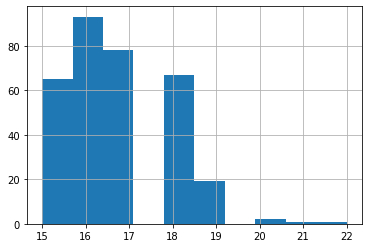

In [392]:
for_num_col(stud_math['age'])

# Столбец возраста:
Пропуски отсутствуют. Основная масса учеников в возрасте от 15 до 18 лет.
Есть незначительное число выбросов: те кто старше 21. Нет необходимости их удалять.

<AxesSubplot:>

count    323.000000
mean       2.773994
std        1.095589
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,
Границы выбросов = [-1.0, 7.0]


0      4.0
1      1.0
2      1.0
3      4.0
4      3.0
      ... 
389    1.0
391    3.0
392    1.0
393    3.0
394    1.0
Name: Medu, Length: 326, dtype: float64

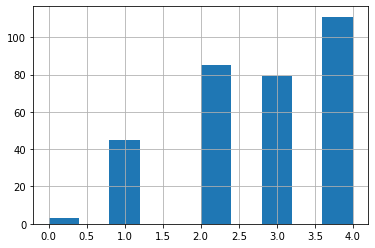

In [393]:
for_num_col(stud_math['Medu'])
# Заменили пропуски на такие же значения в столбце образования отца, т.к. между ними высокая корреляция
for_medu(stud_math['Medu'])

# Столбец образования матери:
Есть 3 пропущеных значения. Видно что у большинства учеников матери достаточно образованны. У трети - имеют высшее образвание.
Выбросов и сомнительных значений нет.

<AxesSubplot:>

count    326.000000
mean       2.521472
std        1.088895
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,
Границы выбросов = [0.5, 4.5]


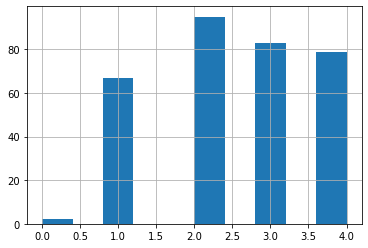

In [394]:
for_num_col(stud_math['Fedu'])

# Столбец образования отца:
Пропусков и выбросов, после предварительной обработки нет.
Как видим образованиеу отцов в среднем ниже чем у матерей.

<AxesSubplot:>

count    303.000000
mean       1.465347
std        0.708010
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,
Границы выбросов = [-0.5, 3.5]


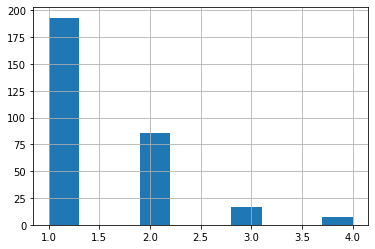

In [395]:
for_num_col(stud_math['traveltime'])
# заменим пропуски медианой
stud_math['traveltime'] = stud_math['traveltime'].apply(
    lambda x: 1 if pd.isna(x) else x)

# Столбец времени пути до школы:
Есть около 30 пропусков, что составляет чуть менее 10% от общего количества значений. Не является критичным такое количество пропусков. Исходя из формулы, выбросы присутствуют, однако руководствуясь пояснительной к заданию таблицей видим что значения до 4 являются допустимыми, ничего удалять не нужно. В дальнейшем будем считать что выбросов нет если значения в рамках, предусмотренных таблицей. По графику видно что большинство детей живет в 15 минутах ходьбы до школы. Дольше часа до школы добираются единицы учеников.

<AxesSubplot:>

count    321.000000
mean       2.031153
std        0.854562
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,
Границы выбросов = [-0.5, 3.5]


array([2., 3., 1., 4.])

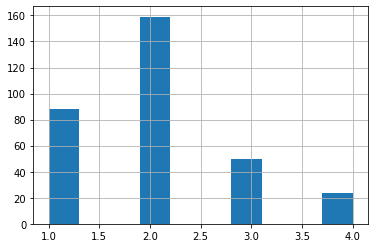

In [396]:
for_num_col(stud_math['studytime'])
# заменим пропуски медианой
stud_math['studytime'] = stud_math['studytime'].apply(
    lambda x: 2 if pd.isna(x) else x)
stud_math['studytime'].unique()

# Столбец времени на учебу вне школы в неделю:
Есть немного пропусков. Выбросов нет. Из графика видно что большинство учеников проводят меньше 5 часов в неделю на учебу вне школы, и лишь немногая часть (около 25 человек) - больше 10 часов.

<AxesSubplot:>

count    307.000000
mean       0.315961
std        0.728396
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,
Границы выбросов = [0.0, 0.0]


array([0., 3., 1., 2.])

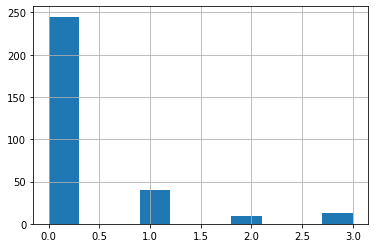

In [397]:
for_num_col(stud_math['failures'])
# заменяем пропуски модой
stud_math['failures'] = stud_math['failures'].apply(
    lambda x: 0 if pd.isna(x) else x)
stud_math['failures'].unique()

# Столбец внешкольных неудач:
Есть около 20 пропусков. Выбросов нет. Подавляющее большинство учеников не имеет проблем вне школы.

<AxesSubplot:>

count    321.000000
mean      -6.093458
std        2.563686
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64

25-й перцентиль: -6.0, 75-й перцентиль: -3.0, IQR: 3.0,
Границы выбросов = [-10.5, 1.5]


array([ -6.,  -9.,  -3., -12.])

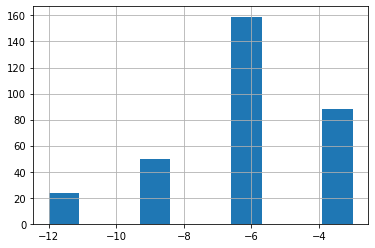

In [398]:
for_num_col(stud_math['studytime, granular'])
# заменяем пропуски медианой
stud_math['studytime, granular'] = stud_math['studytime, granular'].apply(
    lambda x: -6 if pd.isna(x) else x)
stud_math['studytime, granular'].unique()

Не понял что означает данный столбец. Пропуски есть, их можно заменить медианным значением. В дальнейшем посмотрим будет ли коррелироваться данный столбец с целевой переменной, может его и нужно будет оставить.

<AxesSubplot:>

count    326.000000
mean       3.953988
std        0.905215
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,
Границы выбросов = [2.5, 6.5]


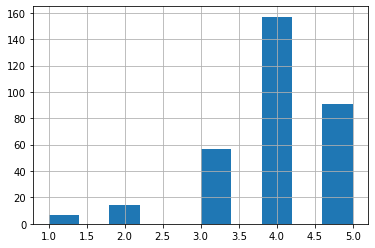

In [399]:
for_num_col(stud_math['famrel'])

# Столбец отношений внутри семьи:
Выбросов и пропусков, после предобработки, нет. Как видно у большинства отношения в семье хорошие. Лишь около 10% учеников имеют проблемы внутри семьи.

<AxesSubplot:>

count    319.000000
mean       3.210031
std        1.004593
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,
Границы выбросов = [1.5, 5.5]


array([3., 2., 4., 1., 5.])

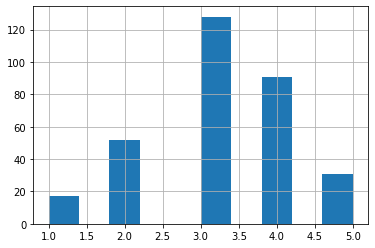

In [400]:
for_num_col(stud_math['freetime'])
# заменяем пропуски медианой
stud_math['freetime'] = stud_math['freetime'].apply(
    lambda x: 3 if pd.isna(x) else x)
stud_math['freetime'].unique()

# Столбец свободного времени у учеников:
Пропусков мало (около 10). Выбросов нет. В целом средние показатели у большинства учащихся. Лишь у единиц почти нет свободного времени. 

<AxesSubplot:>

count    319.000000
mean       3.081505
std        1.098714
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,
Границы выбросов = [-1.0, 7.0]


array([4., 3., 2., 1., 5.])

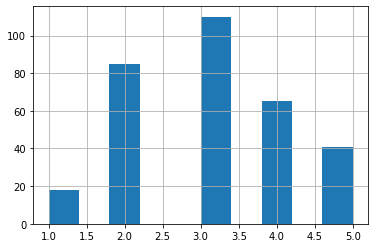

In [401]:
for_num_col(stud_math['goout'])
# заменяем пропуски медианой
stud_math['goout'] = stud_math['goout'].apply(lambda x: 3 if pd.isna(x) else x)
stud_math['goout'].unique()

# Столбец проведения времени с друзьями:
Пропусков мало. Выбросов нет. Опять средние показатели, крайне мало учеников не проводят достаточно времени с друзьями.

<AxesSubplot:>

count    313.000000
mean       3.472843
std        1.391387
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,
Границы выбросов = [0.0, 8.0]


array([3., 5., 1., 2., 4.])

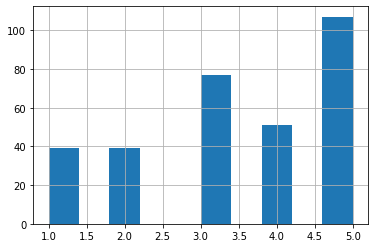

In [402]:
for_num_col(stud_math['health'])
# заменяем пропуски медианой
stud_math['health'] = stud_math['health'].apply(
    lambda x: 4 if pd.isna(x) else x)
stud_math['health'].unique()

# Столбец здоровья:
Пропусков около 15. Выбросов нет. Больше трети учеников абсолютно здоровы. Явные проблемы со здоровьем примерно у четверти. У остальных средние показатели.

<AxesSubplot:>

count    326.000000
mean       5.576687
std        7.410093
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       56.000000
Name: absences, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,
Границы выбросов = [-12.0, 20.0]


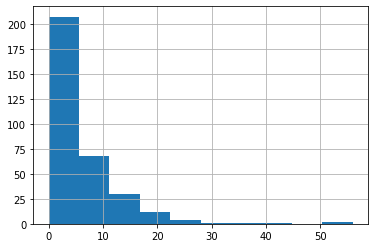

In [403]:
for_num_col(stud_math['absences'])

# Столбец количества пропущенных занятий:
Пропусков нет. В предобработке мы убрали пару аномальных значений, вероятно это единичные прогульщики на показатели которых нет смысла ориентироваться. Выбросы все еще есть, но в рамках здравого смысла.

<AxesSubplot:>

count    326.000000
mean      52.147239
std       22.401712
min        0.000000
25%       41.250000
50%       55.000000
75%       65.000000
max      100.000000
Name: score, dtype: float64

25-й перцентиль: 41.25, 75-й перцентиль: 65.0, IQR: 23.75,
Границы выбросов = [5.625, 100.625]


50.0     50
55.0     42
0.0      30
65.0     28
60.0     25
75.0     25
40.0     24
70.0     23
45.0     19
80.0     16
30.0     14
90.0     10
35.0      8
25.0      5
85.0      3
95.0      2
100.0     1
20.0      1
Name: score, dtype: int64

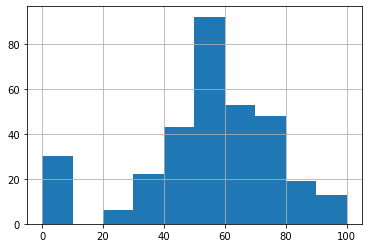

In [404]:
for_num_col(stud_math['score'])

stud_math['score'].value_counts()

# Столбец набранных баллов по экзамену:
После предобработки пропусков нет. Выбросов нет. График симметричный. Подозрение вызывает только большое количесвто оценок 0, пока что их оставим.  Большинство учеников сдали экзамен средне. Этот столбец является для нас целевым, так что пропусков быть не должно.

In [405]:
stud_math.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.135115,-0.152193,0.064970,-0.022439,0.207100,0.022439,0.043593,-0.006911,0.071929,-0.065910,0.156020,-0.140704
Medu,-0.135115,1.000000,0.648857,-0.154519,0.080566,-0.214881,-0.080566,-0.023254,0.004574,0.072493,-0.085160,0.123462,0.203450
Fedu,-0.152193,0.648857,1.000000,-0.165287,-0.000716,-0.248842,0.000716,-0.031771,-0.019721,0.029747,-0.006112,0.068245,0.114783
traveltime,0.064970,-0.154519,-0.165287,1.000000,-0.116920,0.050280,0.116920,-0.061385,0.009030,0.019427,-0.034545,-0.045136,-0.062993
studytime,-0.022439,0.080566,-0.000716,-0.116920,1.000000,-0.132628,-1.000000,0.021887,-0.131594,-0.062756,-0.084767,-0.052771,0.111526
failures,0.207100,-0.214881,-0.248842,0.050280,-0.132628,1.000000,0.132628,0.002215,0.100445,0.080722,0.066805,0.073657,-0.301175
"studytime, granular",0.022439,-0.080566,0.000716,0.116920,-1.000000,0.132628,1.000000,-0.021887,0.131594,0.062756,0.084767,0.052771,-0.111526
famrel,0.043593,-0.023254,-0.031771,-0.061385,0.021887,0.002215,-0.021887,1.000000,0.164395,0.075671,0.107921,-0.034564,0.044338
freetime,-0.006911,0.004574,-0.019721,0.009030,-0.131594,0.100445,0.131594,0.164395,1.000000,0.283774,0.090348,-0.024491,0.014663
goout,0.071929,0.072493,0.029747,0.019427,-0.062756,0.080722,0.062756,0.075671,0.283774,1.000000,-0.012094,0.051960,-0.139746


# Корреляционный анализ
Самая высокая корреляция замечена между образованием матери и отца, это мы использовали для заполнения пропусков в этих столбцах.
С нашей целевой переменной больше всего коррелируют столбцы: Medu, Fedu, studytime. У них корреляция больше 10%.
Также есть высокая обратная корреляция у переменной score со столбцами: age, failures, (studytime, granular), goout.
Эти столбцы точно оставляем для будущей модели. По остальным примем решение после построения boxplot графиков.

# Анализ столбцов с номинативными переменными
Теперь будем анализировать каждый столбец с номинативными переменными отдельно и заполнять пропуски если необходимо. Анализ данных столбцов включает в себя построение boxplot графиков, чтобы посмотреть взаимосвязь целевой переменной и столбца, а также подсчет количества номинативных значений.

,school
GP,288
MS,38


'Количество непустых значений = 326'

<AxesSubplot:>

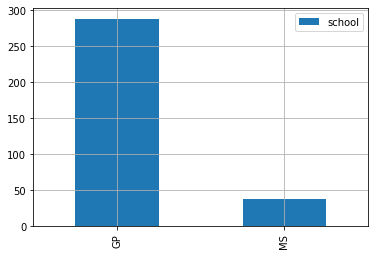

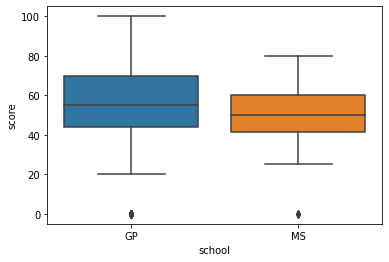

In [406]:
for_obj_col('school')

# Школа
Видим что учащиеся представлены в основном школой GP, и среднее значение баллов у них выше чем в школе MS. Пропусков нет. Столбец может быть полезен для модели.

,sex
F,176
M,150


'Количество непустых значений = 326'

<AxesSubplot:>

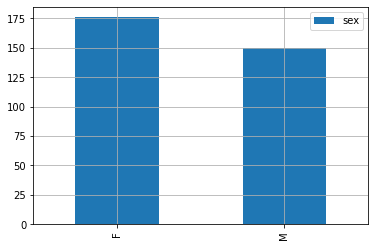

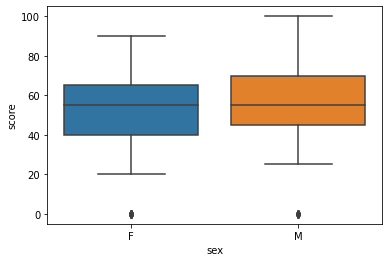

In [407]:
for_obj_col('sex')

# Пол
Примерно равное распрделение в обоих группах. Верхняя граница у мужчин чуть выше, однако средний показатель баллов за экзамен одинаковый. Наверно небольшая закономерность есть.

,address
U,256
R,70


'Количество непустых значений = 326'

<AxesSubplot:>

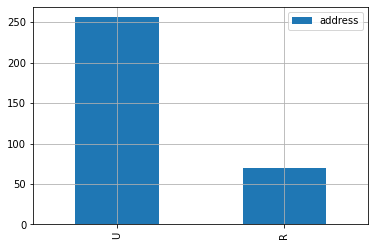

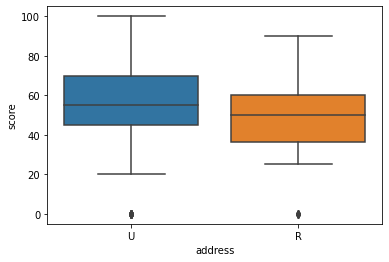

In [408]:
# заполняем пропуски модой
stud_math['address'] = stud_math['address'].apply(
    lambda x: stud_math['address'].mode()[0] if pd.isna(x) else x)
for_obj_col('address')

# Адрес
Большая часть учеников живет в городе. Баллы за экзамен у городских немного выше, столбец также оставляем для модели. Пропуски заполнили модой (городским адресом)

,famsize
GT3,238
LE3,88


'Количество непустых значений = 326'

<AxesSubplot:>

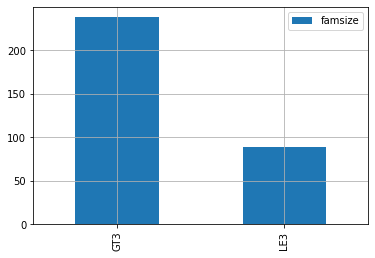

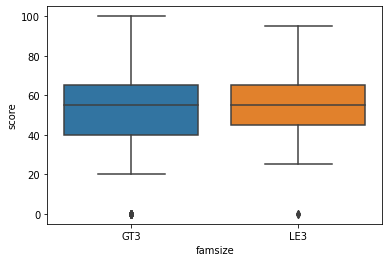

In [409]:
stud_math['famsize'] = stud_math['famsize'].apply(
    lambda x: stud_math['famsize'].mode()[0] if pd.isna(x) else x)
for_obj_col('famsize')

# Размер семьи
Большая часть учеников живет в семьях из 4 и более человек. Однако на итоговую оценку это особого влияния не имеет, баллы в среднем одинаковые. Этот столбец можно отбросить.

,Pstatus
T,299
A,27


'Количество непустых значений = 326'

<AxesSubplot:>

array(['A', 'T'], dtype=object)

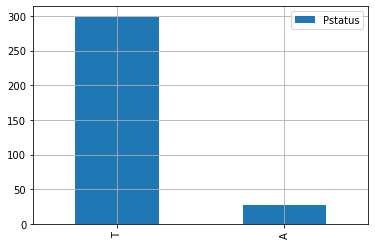

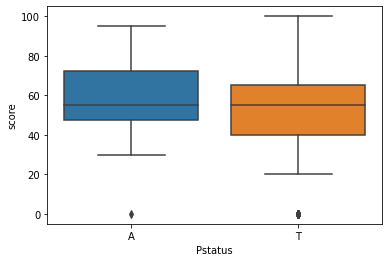

In [410]:
# пропуски заполняем модой
stud_math['Pstatus'] = stud_math['Pstatus'].apply(
    lambda x: stud_math['Pstatus'].mode()[0] if pd.isna(x) else x)
for_obj_col('Pstatus')
stud_math['Pstatus'].unique()

# Статус родителей (вместе живут или раздельно)
У подавляющего большенства учеников родители живут вместе. Межквартильный размах выше у тех чьи родители живут раздельно, однако среднее значение баллов одинаковое у обоих групп. Учитывая столь малое кол-во учеников с раздельно живущими родителями, не могу считать информативным небольшое превосходство межквартильного размаха на их графике. Этот столбец для модели я бы не брал.

,Mjob
other,126
services,77
at_home,51
teacher,43
health,29


'Количество непустых значений = 326'

<AxesSubplot:>

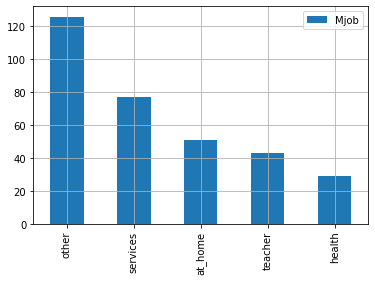

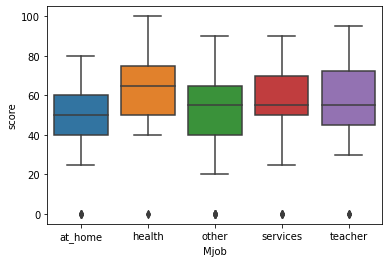

In [411]:
# пропуски заполняем модой
stud_math['Mjob'] = stud_math['Mjob'].apply(
    lambda x: stud_math['Mjob'].mode()[0] if pd.isna(x) else x)
for_obj_col('Mjob')

# Работа матери
Как видим профессия матери имеет достаточно сильное влияние на итоговую оценку ученика. Лучшие результаты показывают те, чьи мама работают в сфере здравоохрание, слабее всех те, у кого мамы домохозяйки или из других профессий. И это при том что пропуски мы заполнили модой (другими профессиями). Данный столбец точно оставляем.

,Fjob
other,197
services,82
teacher,23
at_home,14
health,10


'Количество непустых значений = 326'

<AxesSubplot:>

array(['teacher', 'other', 'health', 'services', 'at_home'], dtype=object)

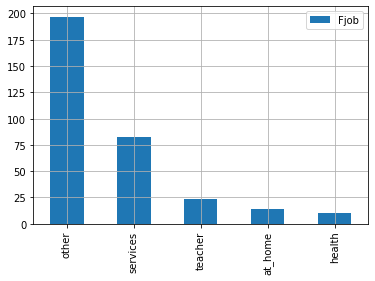

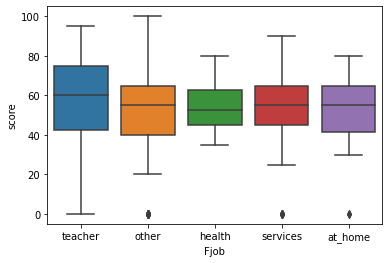

In [412]:
# пропуски заполняем модой (другие профессии)
stud_math['Fjob'] = stud_math['Fjob'].apply(
    lambda x: stud_math['Fjob'].mode()[0] if pd.isna(x) else x)
for_obj_col('Fjob')
stud_math['Fjob'].unique()

# Работа отца
Здесь выделяются ученики у которых отцы учителя, они имеют набольший средний балл, хотя таких учеников не много (около 25). Остальные в среднем сдали экзамен примерно одинаково. Больше всего учеников с отцами работающими в других сферах, думаю это объясняет то. что у них выше всего расположен рахмах. Данный столбец может быть полезен в дальнейшем, его оставим.

,reason
course,121
reputation,88
home,87
other,30


'Количество непустых значений = 326'

<AxesSubplot:>

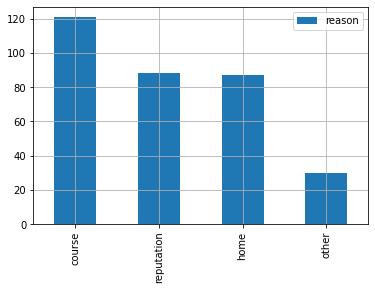

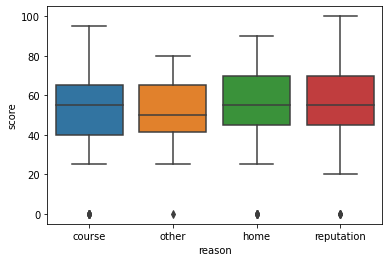

In [413]:
# пропуски заменяем модой
stud_math['reason'] = stud_math['reason'].apply(
    lambda x: stud_math['reason'].mode()[0] if pd.isna(x) else x)
for_obj_col('reason')

# Причина выбора школы
Здесь особых отличий в баллах нет. Только среднее значение у тех учеников, кто руководствовался другими причинами выбора школы, чуть ниже остальных. Не вижу информативности в этом столбце.

,guardian
mother,235
father,70
other,21


'Количество непустых значений = 326'

<AxesSubplot:>

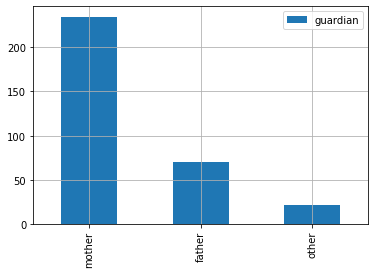

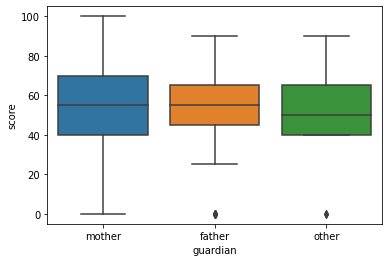

In [414]:
# заменяем пропуски модой
stud_math['guardian'] = stud_math['guardian'].apply(
    lambda x: stud_math['guardian'].mode()[0] if pd.isna(x) else x)
for_obj_col('guardian')

# Опекун
Большинство опекунов - матери. Это объясняет набольший размах на графике именно у тех, у кого мама опекун. Однако баллы за экзамен в среднем одинаковы у всех. Прямой взаимосвязи с целевой переменной у этого столбца мне кажется нет. Не будем этот столбец использовать в модели.

,schoolsup
no,286
yes,40


'Количество непустых значений = 326'

<AxesSubplot:>

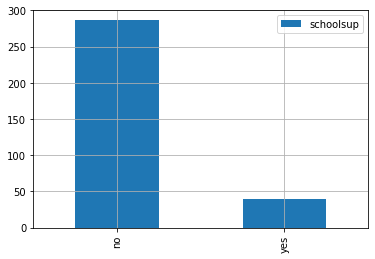

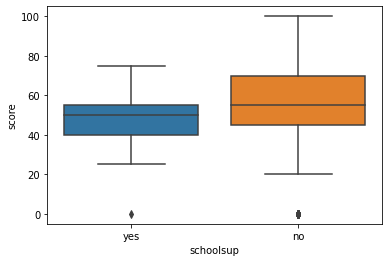

In [415]:
# пропуски заменим модой
stud_math['schoolsup'] = stud_math['schoolsup'].apply(
    lambda x: stud_math['schoolsup'].mode()[0] if pd.isna(x) else x)
for_obj_col('schoolsup')

# Дополнительная образовательная поддержка
Интересный столбец, большинство учеников не имеют доп занятий и у них баллы за экзамен лучше. Можно сделать вывод что на доп занятия ходят только ученики которые слабо успевают по основной программе в школе, чтобы хоть немного наверстать. Однако как видно на экзамене это не сильно помогает. Столбец нужный, взаимосвязь с целевой переменной видна.

,famsup
yes,210
no,116


'Количество непустых значений = 326'

<AxesSubplot:>

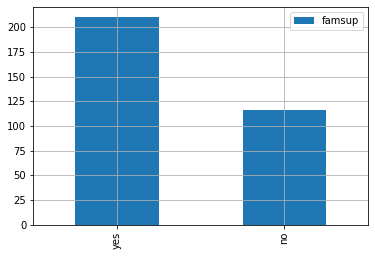

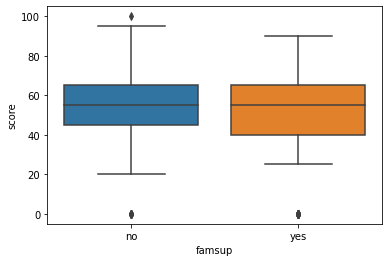

In [416]:
# заполняем пропуски модой
stud_math['famsup'] = stud_math['famsup'].apply(
    lambda x: stud_math['famsup'].mode()[0] if pd.isna(x) else x)
for_obj_col('famsup')

# Семейная образовательная поддержка
В большей части семей ученикам дома помогают, однако на итоговую оценку это влияния не оказывает. Средние показатели за экзамен в обоих случаях одинаковые, только крайние точки на графике и учеников без семейной помощи чуть шире. Прямой закономерности тут не видно, столбец учитывать не будем.

,paid
no,165
yes,128


'Количество непустых значений = 293'

<AxesSubplot:>

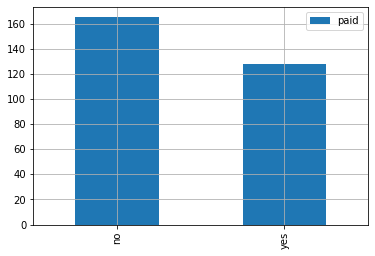

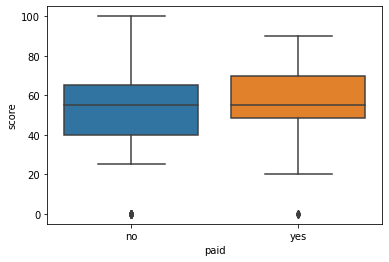

In [417]:
for_obj_col('paid')

# Дополнительные платные занятия
Примерно равное количество тех, кто пользуется платными доп занятиями и тех кто не пользуется. Прямой зависимости тут не вижу. Средние значения у обоих групп одинаковы, а график выше расположен у тех кто не пользуется платными доп занятиями. Заполнять пропуски тут не решился, т.к. обе группы примерно равны по численности, чтобы не вносить лишнюю погрешность. Я бы данный столбец не использовал в дальнейшем, т.к. прямой корреляции нет, данный столбец скорее может вводить в заблуждение.

,activities
yes,161
no,153


'Количество непустых значений = 314'

<AxesSubplot:>

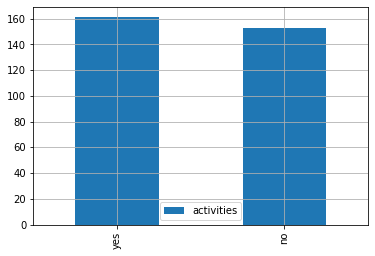

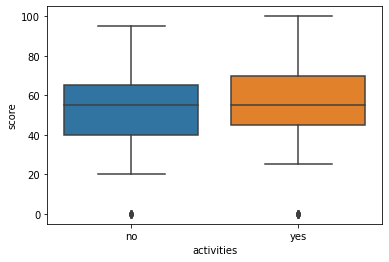

In [418]:
for_obj_col('activities')

# Дополнительные внеучебные занятия
Пропусков в столбце не много, пока что не заполнял их. Обе группы учеников примерно равны. По графикам видно что показатели немного лучше у тех кто посещает внеучебные занятия, размах и межквартильный размах расположены выше, чем у тех кто не посещает. Среднее значение баллов за экзамен примерно равное.

,nursery
yes,262
no,64


'Количество непустых значений = 326'

<AxesSubplot:>

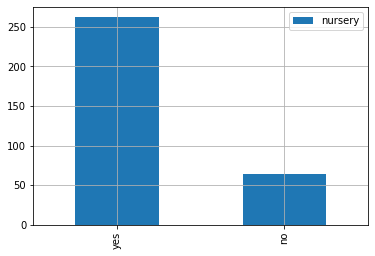

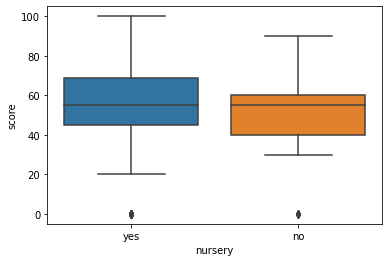

In [419]:
# пропуски заполним модой
stud_math['nursery'] = stud_math['nursery'].apply(
    lambda x: stud_math['nursery'].mode()[0] if pd.isna(x) else x)
for_obj_col('nursery')

# Посещал ли детский сад
Учеников, посещавших детский сад гораздо больше. Однако явного преимущества это не дает, только межквартильный размах шире и расположен чуть выше по оси, возможно это следствие того что таких учеников просто больше. Среднее значение баллов одинаковое. Не считаю что этот столбец может оказываеть влияние на целевую переменную, я бы его не использовал.

,higher
yes,311
no,15


'Количество непустых значений = 326'

<AxesSubplot:>

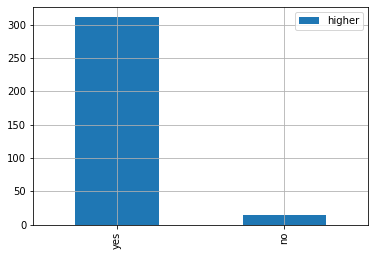

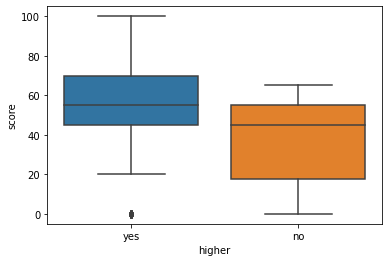

In [420]:
# пропуски заполняем модой
stud_math['higher'] = stud_math['higher'].apply(
    lambda x: stud_math['higher'].mode()[0] if pd.isna(x) else x)
for_obj_col('higher')

# Стремится ли к высшему образованию
Как видим большинство учеников стремятся получить высшее образование. Результат их желаний виден в итоговом экзамене, их результаты значительно выше, чем у тех кто не хочет получать высшее образование. Столбец имеет прямую взимосвязь с целевой переменной, его оставляем.

,internet
yes,278
no,48


'Количество непустых значений = 326'

<AxesSubplot:>

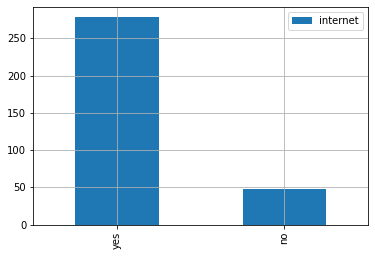

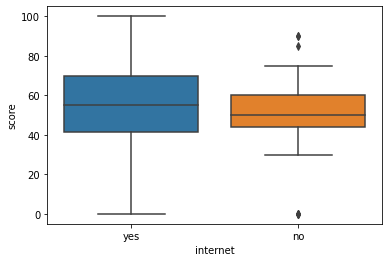

In [421]:
# заполняем пропуски модой
stud_math['internet'] = stud_math['internet'].apply(
    lambda x: stud_math['internet'].mode()[0] if pd.isna(x) else x)
for_obj_col('internet')

# Наличие интернета дома
У большинства интернет дома есть. Те ученики, у кого интернета нет в среднем учатся не плохо, однако высоких баллов за экзамен не имеют. Столбец думаю будет полезен в будущей модели. Сложно быть отличником без интернета.

,romantic
no,224
yes,102


'Количество непустых значений = 326'

<AxesSubplot:>

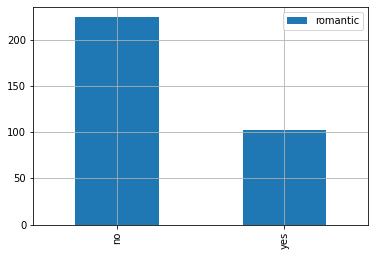

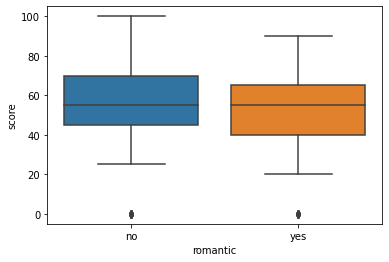

In [422]:
# пропуски заполняем модой
stud_math['romantic'] = stud_math['romantic'].apply(
    lambda x: stud_math['romantic'].mode()[0] if pd.isna(x) else x)
for_obj_col('romantic')

# Находится ли в романтических отношениях
Ученики не находящиеся в отношениях имеют чуть более высокие баллы, размах и межквартильный размах расположены выше по оси баллов. Среднее значение у обоих групп одинаково. Как видно, влюбленность все таки немного мешает учиться, отсюда и хуже график у тех кто влюблен. Данный столбец можно оставить, корреляция в нем с нашей переменной есть.

# Вывод по номинативным столбцам
Столбцы, в которых вывляена взаимосвязь с целевой переменной score : school, sex, address, Mjob, Fjob, schoolsup, activities, higher, internet, romantic.

# Построение boxplot графиков для числовых столбцов
Теперь попробуем посмотреть на числовые столбцы, у которых не было высокой корреляции с нашим целевым столбцом score, на графиках boxplot. Может получится выявить что-то полезное.

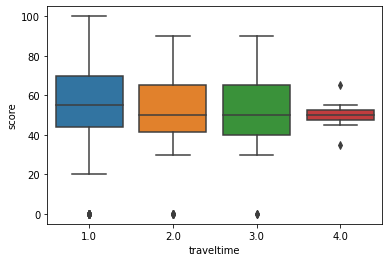

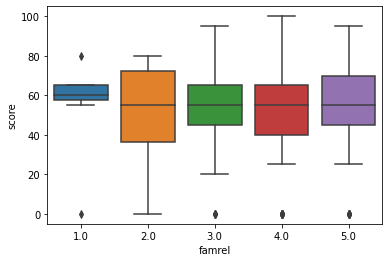

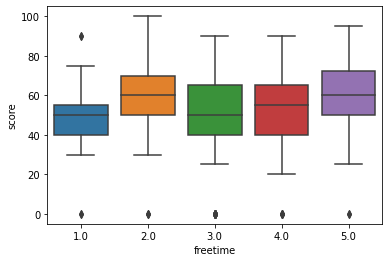

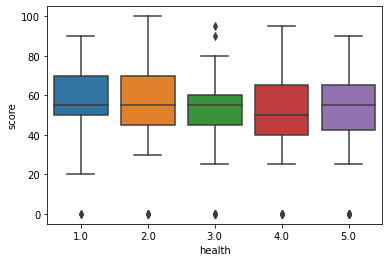

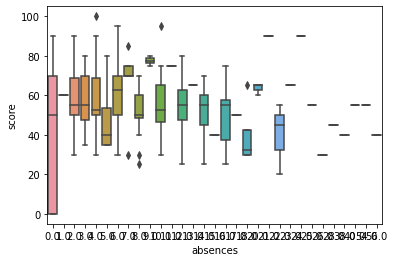

In [423]:
cols_for_box = ['traveltime', 'famrel', 'freetime', 'health', 'absences']
for col in cols_for_box:
    boxplt(col)

# Вывод по графикам boxplot для слабокореелирующих числовых столбцов
Из 5 рассмотенных столбцов вижу смысл оставть только 1, столбец свободного времени после школы (freetime), т.к. есть интересная закономерность, что лучше всего сдают экзамен либо ученики у которых его в меру мало (а значит дома. либо на доп занятиях усердно занимаются), либо наоборот очень много (скорее всего у способных учеников, которым достаточно времени в школе чтобы все понять и разобраться). Востальных столбцах интересных особенностей или прямых зависимостей не обнаружено.

# Итоговый вывод
## В результате EDA для анализа влияния различных характеристик учеников на их итоговую оценку по экзамену по математике были получены следующие выводы:
1. В данных достаточно мало пропусков, они были в некоторых столбцах и до 10% от общего числа данных в столбце
2. Выбросы были лишь единичные в некоторых столбцах, и некоторые в целевом score, которые сразу пришлось удалить
3. Один столбец studytime, granular был представлен без пояснения значений в нем, я для себя не определил что он означает, так что в своей модели бы не использовал его. Однако он имеет положительную корреляцию с целевой переменной, так что для кого-то может быть полезен.
4. Корреляционный анализ показал что наибольшая прямая корреляция у целевой переменной score - с образованием матери Medu, а обратная корреляция наибольшая с возрастом age и провалами failures, т.е. чем младше ученик и меньше косячит вне учебного процесса, тем лучше сдает экзамен.
5. По номинативным переменным из явных закономерностей это: стремление ученика к высшему образованию higher, и профессии родителей Mjob и Fjob имеют наибольшее явное влияние на итоговый балл за экзамен.
6. В целом для построения будущей модели я выбрал следующие параметры: age, Medu, Fedu, studytime, failures, goout, school, sex, address, Mjob, Fjob, schoolsup, activities, higher, internet, romantic.



In [425]:
for_model = stud_math.loc[:, ['age', 'Medu', 'Fedu', 'studytime', 'failures', 'goout', 'school', 'sex', 'address', 'Mjob', 'Fjob', 'schoolsup', 'activities', 'higher', 'internet', 'romantic', 'score']]
display(for_model)

,age,Medu,Fedu,studytime,failures,goout,school,sex,address,Mjob,Fjob,schoolsup,activities,higher,internet,romantic,score
0,18,4.0,4.0,2.0,0.0,4.0,GP,F,U,at_home,teacher,yes,no,yes,yes,no,30.0
1,17,1.0,1.0,2.0,0.0,3.0,GP,F,U,at_home,other,no,no,yes,yes,no,30.0
2,15,1.0,1.0,2.0,3.0,2.0,GP,F,U,at_home,other,yes,no,yes,yes,no,50.0
3,15,4.0,2.0,3.0,0.0,2.0,GP,F,U,health,other,no,yes,yes,yes,yes,75.0
4,16,3.0,3.0,2.0,0.0,2.0,GP,F,U,other,other,no,no,yes,no,no,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,18,1.0,1.0,2.0,1.0,1.0,MS,F,U,other,other,no,yes,yes,yes,no,0.0
391,17,3.0,1.0,1.0,0.0,5.0,MS,M,U,services,services,no,no,yes,yes,no,80.0
392,21,1.0,1.0,1.0,3.0,3.0,MS,M,R,other,other,no,no,yes,no,no,35.0
393,18,3.0,2.0,1.0,0.0,1.0,MS,M,R,services,other,no,NaN,yes,yes,no,50.0
